# HSE 2024: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [17]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

Градиент для Elastic Net Loss равен:

$$ \nabla_w L(w, w_0) = X^\top(\sigma(Xw) - y) + \gamma \,sign(w) + 2 \beta w$$, где k - длина списка w


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [64]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [19]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    n = X.shape[0]
    w = np.array(w)
    z = np.dot(X, w)
    pred = sigmoid(z)
    log_loss = -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))

    l1 = gamma * np.sum(np.abs(w))

    l2 = beta * np.sum(w ** 2)

    final_loss = log_loss + l1 + l2
    return final_loss

#### 3. [0.25 points] Implement the gradient (as a function)

In [20]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    w = np.array(w)

    z = X @ w
    y_pred = sigmoid(z)
    error = y_pred - y

    grad_w = X.T @ error

    grad_w += gamma * np.sign(w) + 2 * beta * w

    return grad_w

#### Check yourself

In [21]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [108]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.loss_history = []
        self.classes_ = None

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.classes_ = np.unique(y)
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        self.w = np.random.randn(n_features)

        for i in range(self.max_iter):
            ls = self.loss(X, y, self.w, self.gamma, self.beta)
            self.loss_history.append(ls)
            grad_w = self.get_grad(X, y, self.w, self.gamma, self.beta)
            if np.linalg.norm(grad_w) < self.tolerance:
                break
            self.w -= self.lr * grad_w

        return self

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        # your code here
        return (self.predict_proba(X)[1] >= 0.5).astype(int)


    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])


    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, X, y, w: List[float], gamma=1., beta=1.) -> float:

        epsilon = 1e-15
        n = X.shape[0]
        w = np.array(w)
        z = np.dot(X, w)
        pred = self.sigmoid(z)

        pred = np.clip(pred, epsilon, 1 - epsilon)
        log_loss = -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))

        l1 = gamma * np.sum(np.abs(w))

        l2 = beta * np.sum(w ** 2)

        final_loss = log_loss + l1 + l2
        return final_loss


    def get_grad(self, X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
        w = np.array(w)

        z = X @ w
        y_pred = self.sigmoid(z)
        error = y_pred - y

        grad_w = X.T @ error

        grad_w += gamma * np.sign(w) + 2 * beta * w

        return grad_w

In [85]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [25]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

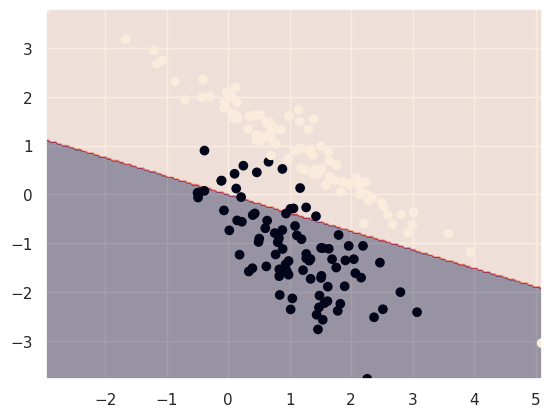

In [26]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

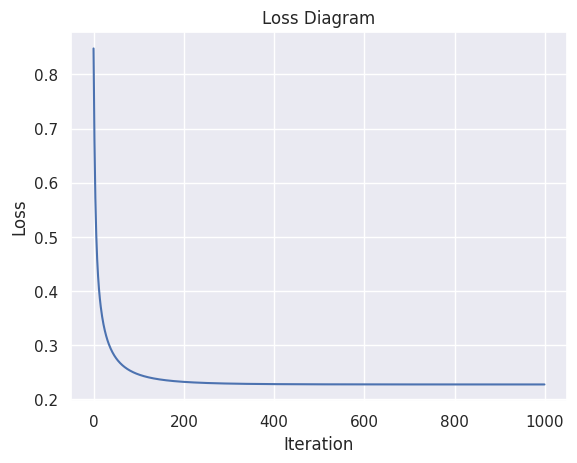

In [27]:
plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Diagram')
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [86]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

param_grids = {
    'linear': {'C': [0.1, 1, 10, 100]},
    'poly': {'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'coef0': [0, 1]},
    'rbf': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
}


In [91]:
results = []

for kernel, grid in param_grids.items():
    svc = SVC(kernel=kernel, probability=True, random_state=42)
    grid_search = GridSearchCV(svc, grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)


    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]


    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'kernel': kernel,
        'best_params': grid_search.best_params_,
        'accuracy': acc,
        'roc_auc': roc_auc,
        'f1_score': f1
    })

    print(f"\nKernel: {kernel}")
    print("Best Params:", grid_search.best_params_)
    print("Accuracy:", acc)
    print("ROC AUC:", roc_auc)
    print("F1 Score:", f1)



Kernel: linear
Best Params: {'C': 1}
Accuracy: 0.9629629629629629
ROC AUC: 1.0
F1 Score: 0.9642857142857143

Kernel: poly
Best Params: {'C': 10, 'coef0': 0, 'degree': 3}
Accuracy: 0.9814814814814815
ROC AUC: 0.9986282578875172
F1 Score: 0.9818181818181818

Kernel: rbf
Best Params: {'C': 10, 'gamma': 0.1}
Accuracy: 0.9629629629629629
ROC AUC: 1.0
F1 Score: 0.9642857142857143


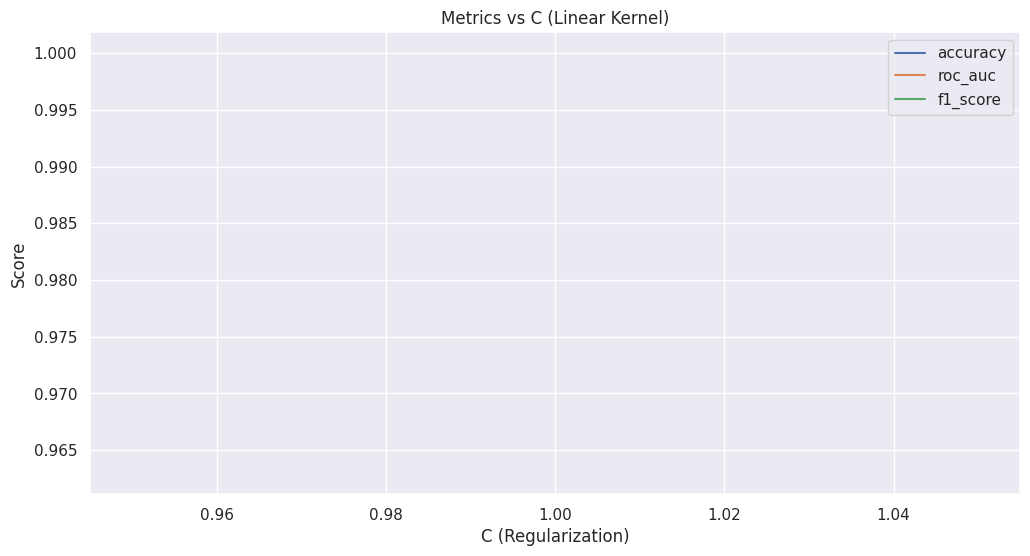

In [94]:
linear_results = [res for res in results if res['kernel'] == 'linear']
c_values = [res['best_params']['C'] for res in linear_results]
metrics = ['accuracy', 'roc_auc', 'f1_score']

plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(c_values, [res[metric] for res in linear_results], label=metric)
plt.xlabel("C (Regularization)")
plt.ylabel("Score")
plt.title("Metrics vs C (Linear Kernel)")
plt.legend()
plt.show()



## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [29]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/poems/
   creating: data/poems/Blok/
  inflating: data/poems/Blok/info.csv  
  inflating: data/poems/Blok/╨¿╤â╤é╨╛╤ç╨╜╤ï╨╡ ╤ü╤é╨╕╤à╨╕ ╨╕ ╤ü╤å╨╡╨╜╨║╨╕.txt  
  inflating: data/poems/Blok/╨Æ╨╛╨╖╨╝╨╡╨╖╨┤╨╕╨╡.txt  
error:  cannot create data/poems/Blok/╨í╤é╨╕╤à╨╛╤é╨▓╨╛╤Ç╨╡╨╜╨╕╤Å 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤ê╨╡╨┤╤ê╨╕╨╡ ╨▓ ╨╛╤ü╨╜╨╛╨▓╨╜╨╛╨╡ ╤ü╨╛╨▒╤Ç╨░╨╜╨╕╨╡.txt
        File name too long
  inflating: data/poems/Blok/╨í╤é╨╕╤à╨╛╤é╨▓╨╛╤Ç╨╡╨╜╨╕╤Å. ╨Ü╨╜╨╕╨│╨░ ╤é╤Ç╨╡╤é╤î╤Å (1907-1916).txt  
  inflating: data/poems/Blok/╨í╤é╨╕╤à╨╛╤é╨▓╨╛╤Ç╨╡╨╜╨╕╤Å. ╨Ü╨╜╨╕╨│╨░ ╨┐╨╡╤Ç╨▓╨░╤Å (1898-1904).txt  
  inflating: data/poems/Blok/╨í╤é╨╕╤à╨╛╤é╨▓╨╛╤Ç╨╡╨╜╨╕╤Å. ╨Ü╨╜╨╕╨│╨░ ╨▓╤é╨╛╤Ç╨░╤Å (1904-1908).txt  
  inflating: data/poems/Blok/╨í╨║╨╕╤ä╤ï.txt  
  inflating: data/poems/Blok/╨í╨╛╨╗╨╛╨▓╤î╨╕╨╜╤ï╨╣ ╤ü╨░╨┤.txt  
  inflating: data/poems/Blok/╨ö╨▓╨╡╨╜╨░╨┤╤å╨░╤é╤î.txt  
  inflating: data/poems/Blok/╨Ü╨╛╤Ç╤Ç╨╡╤ü╨┐╨╛╨╜╨┤╨╡╨╜╤å╨╕╤Å ╨æ╨░╨╗╤î╨╝╨╛╨╜╤é╨░ ╨╕╨╖ ╨£╨╡╨║╤ü╨╕╨║╨╕.tx

In [30]:
from pathlib import Path
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

# 0
authors = ['Blok', 'Bryusov', 'Chekhov', 'Dostoevsky', 'Gogol', 'Gorky']

# 1
path = 'data/prose/'

sentences = []
for i in authors:
    folder_path = Path(path + i)
    for file_path in folder_path.glob('*.txt'):
        with open(file_path, encoding = 'utf-8') as f:
            text = f.read().replace('\n', ' ')
            split_text = sent_tokenize(text)
            for sentence in split_text:
                if len(sentence) > 15:
                    sentences.append({"sentence": sentence.strip(), "author": i})

sentences_df = pd.DataFrame(sentences)
sentences_df.head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,sentence,author
0,Девушка розовой калитки и муравьиный царь ...,Blok
1,"Из пыльного, безнадежного белого курорта в сти...",Blok
2,"Туристы влезают туда, крутят вверху носами, лю...",Blok
3,"Правда, страна богатая, тучная страна открывае...",Blok
4,"Колесо приводит в движение поршень, тянущийся ...",Blok
5,"Гуляешь вдоль этого поршня, сядешь и покатаешь...",Blok
6,"Жарко невыносимо, нивы наливаются, черешни кра...",Blok
7,А все-таки хорошо (особенно по воспоминанию); ...,Blok
8,Романтическая страна.,Blok
9,В курорте скука - тоже зеленая.,Blok


In [31]:
print(sentences_df.shape)


sample_sizes = [5000, 15000, 8000, 11000, 20000, 3000]
sampled_sentences = pd.DataFrame()

for author, size in zip(authors, sample_sizes):
    author_sentences = sentences_df[sentences_df['author'] == author]
    sampled_sentences = pd.concat([sampled_sentences, author_sentences.sample(n=size, random_state=42, replace=True)])

shuffled_df = sampled_sentences.sample(frac=1).reset_index(drop=True)
shuffled_df.head(10)

(224847, 2)


,sentence,author
0,"нет, вы проведите время с нами!",Gogol
1,"Из большой, наскоро сложенной, кузни валит дым.",Blok
2,Единственной истинной отрадой в жизни Лидии бы...,Bryusov
3,Там обитают бритые сказочные тайные советники.,Blok
4,"Так ведь и все грабежом живут, все друг дружку...",Gorky
5,"Иди в публичный дом, -- там ты за малые деньги...",Bryusov
6,"И в самом деле, Манилов наконец услышал такие ...",Gogol
7,"Федор Тимофеич, редко покидавший свой матрасик...",Chekhov
8,"Он почувствовал сострадание к этой жизни, еще ...",Chekhov
9,"Неужели ты никогда не узнавал, что умер царь,...",Bryusov


In [32]:
import string
from nltk import WordNetLemmatizer, word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))
word_tokenizer = nltk.WordPunctTokenizer()



In [33]:
dates = [str(x) for x in np.arange(1900, 2022)]
def process_data(data):
    texts = []

    for item in data['sentence']:
        text_lower = item.lower()
        tokens = word_tokenizer.tokenize(text_lower)

        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]

        texts.append(tokens)
    return texts

In [34]:
# run tokenization and data cleaning
y = shuffled_df['author']
texts = process_data(shuffled_df)

In [35]:
# example
i = 1
print("Label: ", y[i])
print("Tokens: ", texts[i][:5])

Label:  Blok
Tokens:  ['большой', 'наскоро', 'сложенной', 'кузни', 'валит']


# Нормализация

In [36]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("russian")

In [37]:
i = 1
for aword in texts[i][:10]:
    aword_stem = stemmer.stem(aword)
    print("Before: %s, After: %s" % (aword, aword_stem))


Before: большой, After: больш
Before: наскоро, After: наскор
Before: сложенной, After: сложен
Before: кузни, After: кузн
Before: валит, After: вал
Before: дым, After: дым


In [38]:
for i in range(len(texts)):
    texts[i] = ' '.join([stemmer.stem(x) for x in texts[i]])

In [39]:
# example
i = 1
print("Label: ",   y[i])
print("Text: \n",  texts[i])

Label:  Blok
Text: 
 больш наскор сложен кузн вал дым


# Чето еще

In [40]:
from collections import Counter
print(Counter(y))

Counter({'Gogol': 20000, 'Bryusov': 15000, 'Dostoevsky': 11000, 'Chekhov': 8000, 'Blok': 5000, 'Gorky': 3000})


In [41]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 50)
count_vectors = vectorizer.fit_transform(texts)

vectorizer.get_feature_names_out()[:10]

array(['бог', 'больш', 'ваш', 'вид', 'врем', 'все', 'всем', 'всяк',
       'глаз', 'говор'], dtype=object)

In [42]:
count_vectors.todense()[:2]

matrix([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features = 50)
tfidf_vectors = tfidf_vectorizer.fit_transform(texts)
tfidf_vectorizer.get_feature_names_out()[:10]

array(['бог', 'больш', 'ваш', 'вид', 'врем', 'все', 'всем', 'всяк',
       'глаз', 'говор'], dtype=object)

In [44]:
tfidf_vectors.todense()[:2]

matrix([[0.        , 0.        , 0.        , 0.        , 0.69041469,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.72341382, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [45]:
pair = ['Chekhov', 'Dostoevsky']

df = pd.DataFrame([texts, y]).T
df.columns = ['text', 'author']
df = df[df['author'].isin(pair)]
df.head(10)

,text,author
7,федор тимофеич редк покида сво матрасик вошел ...,Chekhov
8,почувствова сострадан жизн тепл красив вероятн...,Chekhov
10,деревн окол крайн изб дорог стоя як упор гляде...,Chekhov
12,колес завертел вышл тринадца,Dostoevsky
13,ариадн загорел желан еха итал,Chekhov
15,— быва вовс лож особлив ежел хорош компан прос...,Chekhov
20,эт скор придет над молод,Dostoevsky
22,зна эт сам ... господин молод человек — им чес...,Chekhov
23,— черт возьм,Chekhov
27,мал любв поэт,Dostoevsky


In [97]:
from sklearn.model_selection import train_test_split
df['label'] = (df['author'] == pair[0]).astype(int)
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
vectorizer = TfidfVectorizer(max_features = 100)

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [102]:
from sklearn.metrics import *

def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-82-e09266854224>:55: RuntimeWarning: overflow encountered in square
  l2 = beta * np.sum(w ** 2)
<ipython-input-82-e09266854224>:44: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-82-e09266854224>:51: RuntimeWarning: divide by zero encountered in log
  log_loss = -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))
<ipython-input-82-e09266854224>:55: RuntimeWarning: overflow encountered in square
  l2 = beta * np.sum(w ** 2)
<ipython-input-82-e09266854224>:44: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-82-e09266854224>:51: RuntimeWarning: divide by zero encountered in log
  log_loss = -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))
<ipython-input-82-e09266854224>:55: RuntimeWarning: overflow encountered in square
  l2 = beta * np.sum(w ** 2)
<ipython-input-82-e09266854224>:44: RuntimeWarning: overflow encou

Best parameters:  {'beta': 0.1, 'gamma': 0.1, 'lr': 0.1}
Precision:   0.62
Recall:   0.57
F1-measure:   0.48
Accuracy:   0.52
ROC-AUC  =    0.57




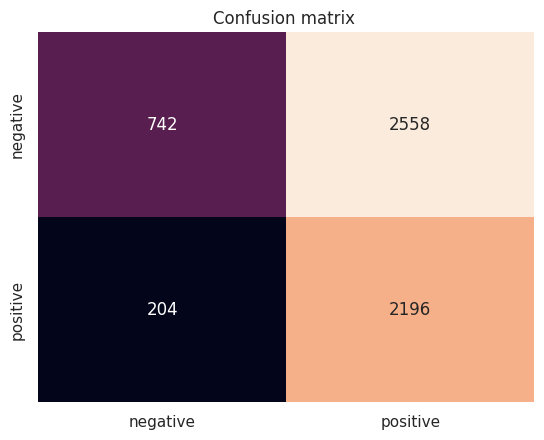

In [83]:
from sklearn.model_selection import GridSearchCV

logit_params = {
    'beta': [0.01, 0.1, 1.0, 10],
    'gamma': [0.01, 0.1, 1.0, 10],
    'lr': [0.001, 0.01, 0.1, 1]
}


logit_model = Logit(max_iter=1000, tolerance=1e-4, random_state=42)
clf = GridSearchCV(logit_model, logit_params, scoring='f1', cv=5, error_score='raise')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba  = clf.predict_proba(X_test)
print('Best parameters: ', clf.best_params_)
show_results(y_test, pred, proba)

In [81]:
from sklearn.svm import SVC


svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}


svc_model = SVC(random_state=42, probability=True)
svc_grid = GridSearchCV(svc_model, svc_params, scoring='f1', cv=5)
svc_grid.fit(X_train, y_train)


print("Best SVM Parameters:", svc_grid.best_params_)


Best SVM Parameters: {'C': 10, 'kernel': 'rbf'}


Best parameters:  {'C': 10, 'kernel': 'rbf'}
Precision:   0.61
Recall:   0.58
F1-measure:   0.57
Accuracy:   0.62
ROC-AUC  =    0.60




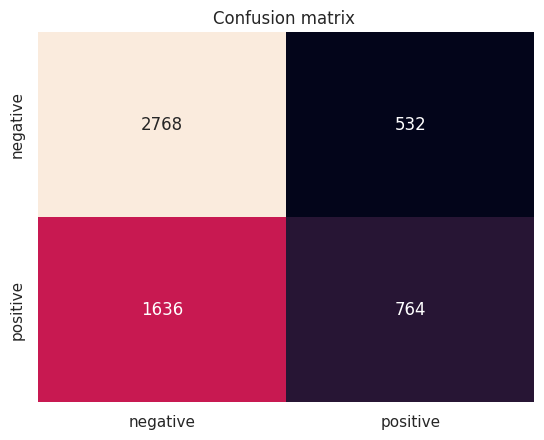

In [103]:
svc_best = svc_grid.best_estimator_
pred = svc_grid.predict(X_test)
proba  = svc_grid.predict_proba(X_test)
print('Best parameters: ', svc_grid.best_params_)
show_results(y_test, pred, proba)

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

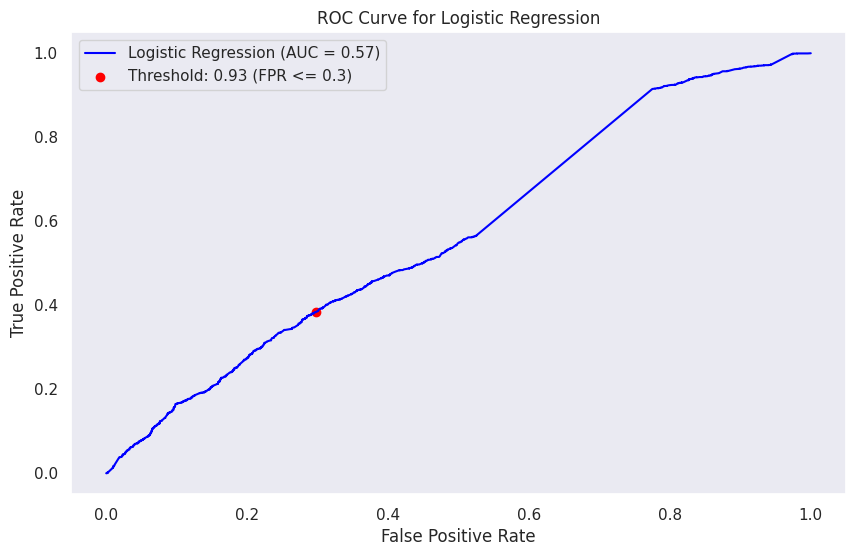

Logistic Regression - Chosen Threshold: 0.93, FPR: 0.30, TPR: 0.38


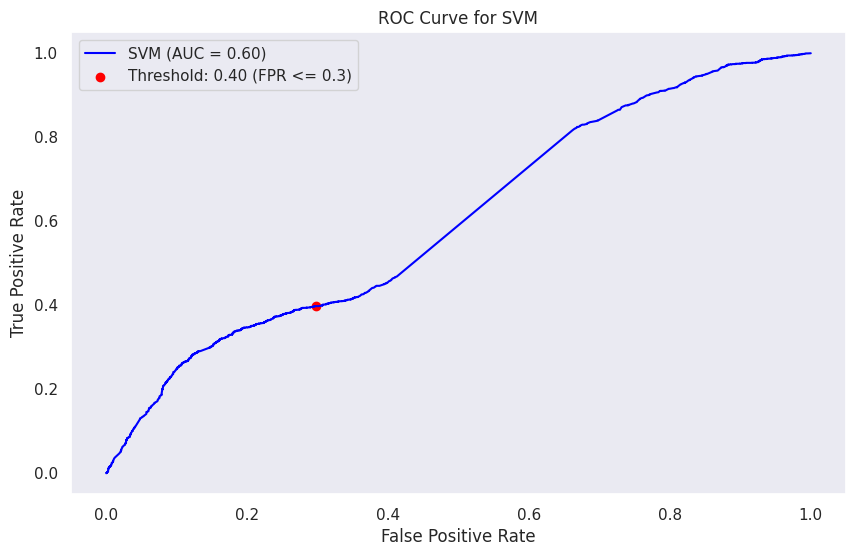

SVM - Chosen Threshold: 0.40, FPR: 0.30, TPR: 0.40


In [133]:
def plot_roc_with_thresholds(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)
    if y_proba[0].shape[0] > 2:
        y_proba = y_proba.T
    y_proba = y_proba[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    fpr_30_idx = max(i for i, f in enumerate(fpr) if f <= 0.3)
    threshold_30 = thresholds[fpr_30_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})", color='blue')
    plt.scatter(fpr[fpr_30_idx], tpr[fpr_30_idx], color='red', label=f"Threshold: {threshold_30:.2f} (FPR <= 0.3)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {label}")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"{label} - Chosen Threshold: {threshold_30:.2f}, FPR: {fpr[fpr_30_idx]:.2f}, TPR: {tpr[fpr_30_idx]:.2f}")


plot_roc_with_thresholds(clf, X_test, y_test, "Logistic Regression")


plot_roc_with_thresholds(svc_grid, X_test, y_test, "SVM")


In [135]:
def evaluate_at_threshold(model, X_test, y_test, threshold):
    y_proba = model.predict_proba(X_test)
    if y_proba[0].shape[0] > 2:
        y_proba = y_proba.T
    y_proba = y_proba[:, 1]

    y_pred = (y_proba >= threshold).astype(int)


    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Confusion Matrix:\n{cm}")


evaluate_at_threshold(clf, X_test, y_test, threshold=0.3)

evaluate_at_threshold(svc_grid, X_test, y_test, threshold=0.3)


Precision: 0.45
Recall: 0.94
F1 Score: 0.61
Confusion Matrix:
[[ 559 2741]
 [ 147 2253]]
Precision: 0.43
Recall: 1.00
F1 Score: 0.60
Confusion Matrix:
[[  69 3231]
 [  11 2389]]


### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [ ]:
# your code here